In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

#from mpltools import special ##leon

plt.style.use('ggplot')

class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1
        self.keytime=keytime # 2
        self.ttime=ttime # 3
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx
        self.hmd_ry=hmd_ry
        self.hmd_rz=hmd_rz

def read_data(file,rawdata):
    print("Reading %s"%file)
    seperator="\t"
    with open(file,"r") as fp:
        for line in fp:
            if line.startswith("Time"):
                continue
            l=line[:-1]
            f=l.split(seperator) 
            if(int(f[3])==1):
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
            else: 
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))
                
    return rawdata

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime
        
class posDataClass(object):
    def __init__(self,targetid,target_lon,target_lat,zeroTime,relativeTime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.zeroTime=zeroTime
        self.relativeTime = relativeTime

def process_time(raw_data):
    timeData={}
    filteredData=[a for a in raw_data if a.keypress==1]
    for i in range(len(filteredData)-1):
        if(filteredData[i+1].targetid!=filteredData[i].targetid):
            continue # when resuming back
        if((i <= len(filteredData)-3) and (filteredData[i-1].targetid==filteredData[i+2].targetid)):
            continue # when two same targets appear one after one
        deltaTime=filteredData[i+1].ttime-filteredData[i].ttime
        #print(deltaTime, filteredData[i].targetid)

        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        if(key1 in timeData)==False:
            timeData[key1]={}
        if(key2 in timeData[key1])==False:
            timeData[key1][key2]=[]
        
        timeData[key1][key2].append(TimeData(filteredData[i].targetid,filteredData[i].target_lon,filteredData[i].target_lat,deltaTime))
    timeData[str(0)][str(0)]=[]   
    timeData[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))
#    print(timeData['0'][str(180)])
        #print(key1, key2)
    return timeData

def track_head(raw_data):
    posData = {}
    zeroTime = 0
    currentTargetID = 0

    for i in range(len(raw_data)):
        if (raw_data[i].keypress == 1 and raw_data[i].targetid != currentTargetID):
            zeroTime = raw_data[i].ttime
            currentTargetID = raw_data[i].targetid
        continue
        relativeTime = raw_data[i].ttime - zeroTime
        
        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        key3=str(zeroTime)
        if(key1 in timeData)==False:
            posData[key1]={}
        if(key2 in timeData[key1])==False:
            posData[key1][key2]={}
        if(key3 in timeData[key1][key2])==False:
            posData[key1][key2][key3]=[]
        
        posData[key1][key2].append(posDataClass(raw_data[i].targetid,raw_data[i].target_lon,raw_data[i].target_lat, zeroTime, relativeTime))
        
    return posData

def plotTrial(raw_data,fig,raw,col,idx):
    #fig = plt.figure()
    ax = fig.add_subplot(raw,col,idx)
    for i in range(13):
        tx=[a.tx for a in raw_data if a.keypress==1]
        ty=[a.ty for a in raw_data if a.fittstrial==trial and a.tid==i]
        x=[a.x for a in raw_data if a.fittstrial==trial and a.tid==i]
        y=[a.y for a in raw_data if a.fittstrial==trial and a.tid==i]
        z=[a.z for a in raw_data if a.fittstrial==trial and a.tid==i]


        mpl.rcParams['legend.fontsize'] = 7

        ax.scatter(tx,ty)
        ax.plot(x, y, label='tid:'+str(i))
    #ax.legend()


def read_plot(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    #key1=['-30','0','30']
    key1=['0','0','0']
    key2=[30,60,90,120,150,180]
    #return timeData


    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            #if(k1==1 and k2==0):
            #if(k2==0):
            #    m1.append(0)
            #    s1.append(0)
            #    continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
        means.append(m1)
        stddev.append(s1)        
    return means

def read_plot2(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    if (len(timeData) == 1):
        key1=['0']
    #key1=['0']
    key2=[0,30,60,90,120,150,180]
    #return timeData

    
    means=[]
    stddev=[]
    overall=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            overall.extend(data)
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
            
        means.append(m1)
        stddev.append(s1)
    overallMean = np.mean(overall)
    
    
    #if (len(timeData) == 3):
    #    m1=[]
    #    s1=[]
    #    data=[]
    #
     #   for k2 in range(len(key2)):

      #      data.extend([a.deltatime for a in timeData[key1[0]][str(key2[k2])]])
    #     data.extend([a.deltatime for a in timeData[key1[1]][str(key2[k2])]])
     #       data.extend([a.deltatime for a in timeData[key1[2]][str(key2[k2])]])

     #       mean=np.mean(data)
      #      std=np.std(data)
            
       #     m1.append(mean)
        #    s1.append(std)
        
    #print (means) 
    #means.append(m1)
    #stddev.append(s1)
    #print (means) 

    return means,overallMean


def read_plot3(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    if (len(timeData) == 1):
        key1=['0']
        print("only one")
    #key1=['0']
    key2=[0,30,60,90,120,150,180]
    #return timeData

    
    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            #angle = math.degrees(math.acos(math.cos(math.radians(30*k1-30)) * math.cos(math.radians(30*k2)))) #k1
            angle = math.sqrt( (30*k1-30)*(30*k1-30) + (30*k2)*(30*k2) ) # for 1,2 approximately
            #angle = 30*k2 # for condition 3,4,5 only
            speed=[]
            #print(str(data))
            
            for i in range(len(data)):
            #    print(str(angle),str(data[i]))
                if (data[i] == 0):
                    speed.append(0)
                    continue
                speed.append(angle / data[i])
                
            #np.true_divide(angle, data)
            mean=np.mean(speed)
            std=np.std(speed)
            
            m1.append(mean)
            s1.append(std)
            
        means.append(m1)
        stddev.append(s1)
    
    if (len(timeData) == 3):
        r=[]
        for j in range(len(means[0])):
            if(means[1][j]==0):
                #r.append(0) # speed = 0
                r.append( (means[0][j] + means[2][j]) / 2 )
                continue
            r.append( (means[0][j] + means[1][j] + means[2][j]) / 3 ) 
        means.append(r)

        #print (means) 
        #means.append(m1)
        #stddev.append(s1)
        #print (means) 

    return means,stddev

def readSpeed(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    key2=[0,30,60,90,120,150,180]
    if (len(timeData) == 1):
        key1=['0']
        key2=[30,60,90,120,150,180]

    
    userMeans=[]
    userStd=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            #angle = math.degrees(math.acos(math.cos(math.radians(30*k1-30)) * math.cos(math.radians(30*k2)))) #k1
            angle = math.sqrt( (30*k1-30)*(30*k1-30) + (30*k2)*(30*k2) ) # for 1,2 approximately
            #angle = 30*k2 # for condition 3,4,5 only
            speed=[]
            #print(str(data))
            
            for i in range(len(data)):
            #    print(str(angle),str(data[i]))
                if (data[i] == 0):
                    speed.append(0)
                    continue
                speed.append(angle / data[i])
                
            #np.true_divide(angle, data)
            
            m1.append(np.mean(speed))
            s1.append(np.std(speed))
   
        userMeans.append(m1)
        userStd.append(s1)
    
    #if (len(timeData) == 3):
    #    r=[]
    #    for j in range(len(means[0])):
    #        if(means[1][j]==0):
    #            #r.append(0) # speed = 0
    #            r.append( (means[0][j] + means[2][j]) / 2 )
    #            continue
    #        r.append( (means[0][j] + means[1][j] + means[2][j]) / 3 ) 
    #    means.append(r)

    return userMeans, userStd

def readTime(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    key2=[0,30,60,90,120,150,180]
    if (len(timeData) == 1):
        key1=['0']
        key2=[30,60,90,120,150,180]

    
    userMeans=[]
    userStd=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            
            m1.append(np.mean(data))
            s1.append(np.std(data))
   
        userMeans.append(m1)
        userStd.append(s1)

    return userMeans, userStd

def make_ratio(mean_before, mean_after):
    
    ratio=[]
    log=[]
    
    for i in range(len(mean_before)):
        r=[]
        l=[]
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                #r.append(1) #ratio
                #l.append(0) #log
                continue
            r.append(mean_before[i][j]/mean_after[i][j]) #ratio
            l.append(-math.log2(mean_before[i][j]/mean_after[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        log.append(l)
        
    return ratio,log


def make_ratio_r(mean_before, mean_after):
    
    ratio=[]
    log=[]
    
    print(len(mean_before))
    for i in range(len(mean_before)):
        r=[]
        l=[]
        print(len(mean_before[i]))
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                #r.append(1) #ratio
                #l.append(0) #log
                continue
            r.append(mean_after[i][j]/mean_before[i][j]) #ratio
            l.append(math.log2(mean_after[i][j]/mean_before[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        log.append(l)
        
    print(np.array(ratio).shape)
    print(np.array(log).shape)
    return ratio,log


def make_ratio_rpluszero(mean_before, mean_after):
    
    ratio=[]
    log=[]
    
    for i in range(len(mean_before)):
        r=[]
        l=[]
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                r.append(1) #ratio
                l.append(0) #log
                continue
            r.append(mean_after[i][j]/mean_before[i][j]) #ratio
            l.append(math.log2(mean_after[i][j]/mean_before[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        log.append(l)
        
    return ratio,log

def make_speed(time):
    
    key1=[-30, 0, 30]
    key2=[0,30,60,90,120,150,180]
    
    speed=[]
    
    for i in range(len(time)-1):
        r=[]
        for j in range(len(time[i])):
            
            if(time[i][j]==0):
                #r.append(0) # speed = 0
                r.append(0)
                continue
            #r.append( (math.sqrt(key1[i] * key1[i] + key2[j] * key2[j])) / mean[i][j] )
            
            r.append( math.degrees(math.acos(math.cos(math.radians(key1[i])) * math.cos(math.radians(key2[j])))) / time[i][j] )
            #print(
        speed.append(r)
    #print("speed0" + str(speed))
    
    if (len(time) == 3):
        r=[]
        for j in range(len(time[1])):
            if(time[1][j]==0):
                #r.append(0) # speed = 0
                r.append( (speed[0][j] + speed[2][j]) / 2 )
                continue
            r.append( (speed[0][j] + speed[1][j] + speed[2][j]) / 3 ) 
        speed.append(r)
    
    #print("speed1" + str(speed))
        
    return speed

def plotbar(r,s=None):
    
    plt.figure(1, figsize = (9,16))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(7)
    width = 0.2
    offset = 0.4
    ax = plt.gca()
    
    plt.bar(x-offset,r[0], width, label="-30", color="C0")
    plt.bar(x,r[1], width, label="0", color="C1")
    plt.bar(x+offset,r[2], width, label="30", color="C2")

    ax.set_xlabel('Group')
    ax.set_ylabel('Scores')
    
    ax.legend()
    plt.xticks(x,key2)
    plt.show()
    
def plotcontrast(r1,r2,r3,s1,s2,s3):

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(7)
    width = 0.2
    offset = 0.4
    opacity = 0.2
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    plt.bar(x-offset*0.5,r1, width, label="-30", color="C0", alpha=1-opacity, yerr=s1)
    plt.bar(x,r2, width, label="0", color="C0", alpha=1-2*opacity, yerr=s2)
    plt.bar(x+offset*0.5,r3, width, label="30", color="C0", alpha=1-3*opacity, yerr=s3)

    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Speed')
    
    ax.legend(title="Latitude", loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    
    plt.show()
    
    
def plotcontrast2(r,s):
    
    r=np.array(r)
    s=np.array(s)

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(3)
    width = 0.1
    offset = 0.1
    opacity = 0.1
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    plt.bar(x-3*offset, r.T[0], width, label="0", color="C0", alpha=1-opacity, yerr=s.T[0])
    plt.bar(x-2*offset, r.T[1], width, label="30", color="C0", alpha=1-opacity*2, yerr=s.T[1])
    plt.bar(x-offset, r.T[2], width, label="60", color="C0", alpha=1-opacity*3, yerr=s.T[2])
    plt.bar(x       , r.T[3], width, label="90", color="C0", alpha=1-opacity*4, yerr=s.T[3])
    plt.bar(x+offset, r.T[4], width, label="120", color="C0", alpha=1-opacity*5, yerr=s.T[4])
    plt.bar(x+2*offset, r.T[5], width, label="150", color="C0", alpha=1-opacity*6, yerr=s.T[5])
    plt.bar(x+3*offset, r.T[6], width, label="180", color="C0", alpha=1-opacity*7, yerr=s.T[6])

    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Speed')
    
    ax.legend(title="Latitude", loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    
    plt.show()
    
def plotcontrast3(r1,r2,s1,s2):
    
    r1=np.array(r1)
    s1=np.array(s1)
    r2=np.array(r2)
    s2=np.array(s2)

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(3)
    width = 0.05
    offset = 0.12
    opacity = 0.1
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    #for i in range(7):
    #    plt.bar(x+(i-3)*offset, r2.T[i], width, label=str(i*30), color="C3", alpha=1-opacity*i)
    #    plt.bar(x+(i-3)*offset, r1.T[i], width, label=str(i*30), color="C4", alpha=1-opacity*i)
        
    for i in range(7): 
        plt.bar(x+(i-3)*offset, r1.T[i], width, yerr=s1.T[i], label=str(i*30), color="C0", alpha=1-opacity*i)
        plt.bar(x+(i-3)*offset+width, r2.T[i], width, yerr=s2.T[i], label=str(i*30), color="C3", alpha=1-opacity*i)
        

    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Speed')
    
    ax.legend(title="Longitude", loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    
    plt.show()
    
def plotContrastSingle(r1, kind):
    
    r1=np.array(r1)
    
    if (kind=='p-value'):
        ymax=0.2
        yref1=0.01
        yref2=0.05
        yref3=0.1

    plt.figure(1, figsize = (12,16))
    
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    
    plt.subplot(2, 1, 1)
    
    x = np.arange(3)
    width = 0.05*2
    offset = 0.12
    opacity = 0.1
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
        
    for i in range(7): 
        plt.bar(x+(i-3)*offset, r1.T[i], width, label=str(i*30), color="C2", alpha=1-opacity*i)

    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Latitude")
    ax.set_xlabel('Target Longitude')
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.axhline(y=yref1,linewidth=1, color='r')
    plt.axhline(y=yref2,linewidth=1, color='r')
    plt.axhline(y=yref3,linewidth=1, color='r')
    plt.xticks(x,key1)
    
    plt.subplot(2, 1, 2)
    
    x = np.arange(7)
    width = 0.1*2
    offset = 0.1
    opacity = 0.2
  
    #for i in range(7):
    plt.bar(x-2*offset,r1[0], width, label="-30", color="C2", alpha=1-opacity)

    plt.bar(x,r1[1], width, label="0", color="C2", alpha=1-2*opacity)

    plt.bar(x+2*offset,r1[2], width, label="30", color="C2", alpha=1-3*opacity)

    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude")
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.axhline(y=yref1,linewidth=1, color='r')
    plt.axhline(y=yref2,linewidth=1, color='r')
    plt.axhline(y=yref3,linewidth=1, color='r')
    plt.xticks(x,key2)
    
    plt.show()
    
def plotcontrast4(r1,r2,s1,s2, kind):
    
    print(np.array(r1).shape)
    print(np.array(r2).shape)
    print(np.array(s1).shape)
    print(np.array(s2).shape)
    
    r1=np.array(r1)
    s1=np.array(s1)
    r2=np.array(r2)
    s2=np.array(s2)
    
    lonMean1=[]
    lonMean2=[]
    latMean1=[]
    latMean2=[]
    
    lonStd1=[]
    lonStd2=[]
    latStd1=[]
    latStd2=[]
    
    for i in range(3):
        latMean1.append(np.mean(r1[i]))
        latStd1.append(np.std(r1[i]))
        latMean2.append(np.mean(r2[i]))
        latStd2.append(np.std(r2[i]))
    
    for i in range(7):
        lonMean1.append(np.mean(r1.T[i]))
        lonStd1.append(np.std(r1.T[i]))
        lonMean2.append(np.mean(r2.T[i]))
        lonStd2.append(np.std(r2.T[i]))
        
    if (kind=='Speed'):
        ymax = 100
    else:
        ymax = 10
        
    plt.figure(1, figsize = (12,32))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    
    plt.subplot(4, 1, 1)
    x = np.arange(7)
    width = 0.1
    offset = 0.1
    opacity = 0.2
  
    #for i in range(7):
    plt.bar(x-3*offset,r1[0], width, label="-30(N)", color="C0", alpha=1-opacity, yerr=s1[0])
    plt.bar(x-2*offset,r2[0], width, label="-30(A)", color="C3", alpha=1-opacity, yerr=s2[0])
    plt.bar(x-0.5*offset,r1[1], width, label="0(N)", color="C0", alpha=1-2*opacity, yerr=s1[1])
    plt.bar(x+0.5*offset,r2[1], width, label="0(A)", color="C3", alpha=1-2*opacity, yerr=s2[1])
    plt.bar(x+2*offset,r1[2], width, label="30(N)", color="C0", alpha=1-3*opacity, yerr=s1[2])
    plt.bar(x+3*offset,r2[2], width, label="30(A)", color="C3", alpha=1-3*opacity, yerr=s2[2])
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    
    plt.xticks(x,key2)
    
    
    
    plt.subplot(4, 1, 2)
     
    plt.bar(x-offset,lonMean1, 2*width, label="N", color="C0", alpha=1-opacity, yerr=lonStd1)
    plt.bar(x+offset,lonMean2, 2*width, label="A", color="C3", alpha=1-opacity, yerr=lonStd2)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Condition", loc=2)
    ax.set_xlabel('Latitude')
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.xticks(x,key2)
    
    
    
    plt.subplot(4, 1, 3)
    
    x = np.arange(3)
    width = 0.05
    gap = 0.02
    opacity = 0.1
    
    for i in range(7):
        plt.bar(x+(i-3)*(gap+2*width)-0.5*width,r1.T[i], width, label=str(30*i), color="C0", alpha=1-opacity*i, yerr=s1.T[i])
        plt.bar(x+(i-3)*(gap+2*width)+0.5*width,r2.T[i], width, label=str(30*i), color="C3", alpha=1-opacity*i, yerr=s2.T[i])
        
       # width,width,gap,width,width,gap,width,width,gap,width|width,gap,width,width,gap,width,width,gap,width,width
        #plt.bar(x+(i-3)*offset, r1.T[i], width, yerr=s1.T[i], label=str(i*30), color="C0", alpha=1-opacity*i)
        #plt.bar(x+(i-3)*offset+width, r2.T[i], width, yerr=s2.T[i], label=str(i*30), color="C3", alpha=1-opacity*i)
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.legend(title="Longitude")
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.xticks(x,key1)
    
    
    
    plt.subplot(4, 1, 4)
    
    plt.bar(x-1.5*width,latMean1, 3*width, label='N', color="C0", alpha=1-opacity, yerr=latStd1)
    plt.bar(x+1.5*width,latMean2, 3*width, label='A', color="C3", alpha=1-opacity, yerr=latStd2)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.legend(title="Condition")
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.xticks(x,key1)
    
    
    
    plt.show()
    

def plotOverall(t1,t2,s1,s2, kind):
    
    overallMean1= np.mean(t1)
    overallStd1= np.std(t1)
    
    overallMean2= np.mean(t2)
    overallStd2= np.std(t2)
    
    if (kind=='Speed'):
        ymax = 100
    else:
        ymax = 5
    
    plt.figure(1, figsize = (12,16))
    key1=['','']
    key2=[1,2,3,4,5,9,10,14,6,13,8,12,11,7]
    
    plt.subplot(2, 1, 1)
    
    x = np.arange(1)
    width = 0.5
    opacity = 0.1
    
    plt.bar(x-0.6*width, overallMean1, width, yerr=overallStd1, label="Natural", color="C0", alpha=1-opacity)
    plt.bar(x+0.6*width, overallMean2, width, yerr=overallStd2, label="Augmented", color="C1", alpha=1-opacity)
    plt.xlabel('Overall')
    plt.ylabel(kind)
    plt.legend(title="Condition")
    
    plt.ylim(0,ymax) # time
    plt.xticks(x,key1)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    
    
    
    plt.subplot(2, 1, 2)
    
    x = np.arange(len(t1))
    width = 0.3
    offset = 0.3
    opacity = 0.1
    
    plt.grid(True, axis='y')
    
    print(np.array(t1).shape)
    print(str(t1))
    
    plt.bar(x-offset*0.5, t1, width, yerr=s1, label="Natural", color="C0", alpha=1-opacity)
    plt.bar(x+offset*0.5, t2, width, yerr=s2, label="Augmented", color="C1", alpha=1-opacity)
    plt.xlabel('Individual Users')
    plt.ylabel(kind)
    plt.legend(title="Condition")
    
    #ax.legend(title="Latitude", loc = 2)
    plt.ylim(0,ymax) # time
    plt.xticks(x,key2)
    
    ax = plt.gca()
    ax.set_axisbelow(True)
    
    plt.show()   
    

def plotRatio(kind1, kind2, r,s=None):
    plt.figure(1, figsize = (8,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    if (kind1=='Ratio'):
        ylimmin=0
        ylimmax=2
        yref=1
        
    if (kind1=='Log'):
        ylimmin=-1
        ylimmax=1
        yref=0
    
    if (len(r)==3):
        xmean=[]
        for i in range(7):
            if (i==0):
                xmean.append( (r[0][0] + r[2][0]) / 2)
            else:
                xmean.append( (r[0][i] + r[1][i-1] + r[2][i]) / 3)
                              

    if(s!=None):
        
        #print(r[1],s[1],key2)
        #ar1 = np.array(r[1])
        #as1 = np.array(s[1])
        #print(ar1,as1)
        ymax=[[],[],[]]
        ymin=[[],[],[]]
        
        for j in range(3):
            #ymax[j] = []
            for i in range(7):
                if (j==1 and i==0):
                    continue
                ymax[j].append(r[j][i] + s[j][i])
                ymin[j].append(r[j][i] - s[j][i])             
        #color='crimson', color="limegreen" color='C0'
        
        if (len(r[1]) == 7):
            remix=[]
            for i in range(6):
                remix.append(r[1][i+1])
            r[1]=remix
            print(len(r[1]))
            print(str(r))
        
###################### plot 3 latitude, with error/standard deviation  (old, bar)
        #plt.errorbar(key2, r[2], label="30", yerr=s[2], fmt='-x',color='crimson',markersize=10,elinewidth=0.5,capsize=10,capthick=0.5)
        #plt.errorbar(key2, r[1], label="0", yerr=s[1], linewidth=2, fmt = '-x',markersize=10, elinewidth=1,capsize=5,capthick=0.5)
        #plt.errorbar(key2, r[0], label="-30", yerr=s[0], fmt=':v',markersize=10,elinewidth=2,capsize=10,capthick=0.5)

        #ax.errorbar(key2, r[0], label="-30-2",yerr=s[0], linestyle='dotted')       
        #ax.fill_between(key2, np.array(r[1]-s[1]),np.array(r[1]+s[1]), facecolor='blue', alpha=0.5)
        #plt.fill_betweenx(key2,r[1]-s[1], r[1]+s[1])
        
###################### plot 3 latitude, with error/standard deviation (new, area/shade)   
        plt.fill_between(np.array(key2), ymin[0], ymax[0],alpha=0.2, label="-30")
        plt.fill_between(np.array(key3), ymin[1], ymax[1],alpha=0.2, label="0")
        plt.fill_between(np.array(key2), ymin[2], ymax[2],alpha=0.2, label="30")
        
        plt.plot(key2, r[0], ':v', label="-30")
        plt.plot(key3, r[1], '-o', label="0")
        plt.plot(key2, r[2], ':^', label="30")
        
###################### plot single latitude
        #pltid = 0;
        ##plt.fill_between(np.array(key2), ymin[pltid], ymax[pltid],alpha=0.2, label=key1[pltid],color='C'+ str(pltid))
        ##plt.plot(key2, r[pltid], '-x', markersize=10, label=key1[pltid],color='C'+ str(pltid), linewidth =2)
        #plt.plot(key2, xmean[1], '-x', markersize=10, label='all', color='black', linewidth =2) #combine all latitude
######################
    else:
        
        plt.axhline(y=yref,linewidth=1, color='r')
    
        if (len(r)==3):
            plt.plot(key2, r[0], '-v', label="-30", linewidth=0.5) 
            plt.plot(key3, r[1], '-o', label="0", linewidth=0.5)
            plt.plot(key2, r[2], '-^', label="30", linewidth=0.5)
            plt.plot(key2, xmean, '-', label="mean", linewidth=5, alpha=0.5)
            
        if (len(r)==1):
            plt.plot(key3, r[0], '-o', label="With Natural Hand", linewidth=2) 

        
    
#    special.errorfill(key2, means1[0], y_err=stddev1[0], label='sin', label_fill='sin error')
#    special.errorfill(x, y_cos, y_err, label='cos', label_fill='cos error',alpha_fill=0.1)
#    plt.fill_between(key2, means1[2]-stddev1[2], means1[2]+stddev1[2])
###################### set figure scale
    #plt.axhline(y=0,linewidth=1, color='r') #log
    #plt.axhline(y=1,linewidth=1, color='r') #ratio
    plt.xticks(key2)
    plt.ylim(ylimmin,ylimmax) #log
    #plt.ylim(0,100) # speed
    plt.xlim(-10)    
    #plt.rcParams["axes.grid.axis"] ="y"
    #plt.rcParams["axes.grid"] = True
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.legend(title="Latitude")
    plt.ylabel(kind2 + kind1)
    #plt.ylabel('log')
    plt.xlabel('Target Longitude')

    plt.savefig('user'+str(users[uid])+'.pdf')
    plt.show()
    


Reading ../Users/14/3.txt
Reading ../Users/14/4.txt
Reading ../Users/14/5.txt
(1, 6)
(1, 6)
(1, 6)
Reading ../Users/14/3.txt
Reading ../Users/14/4.txt
Reading ../Users/14/5.txt
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)


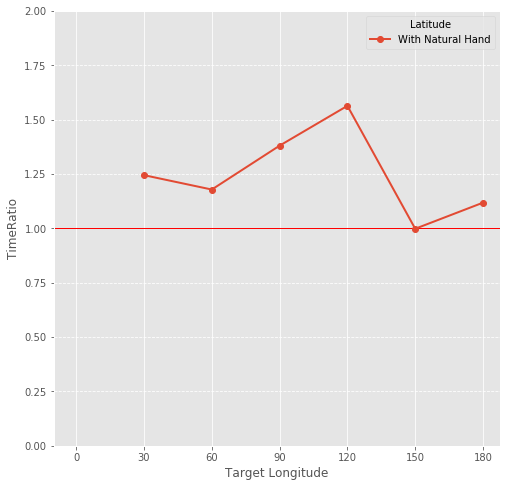

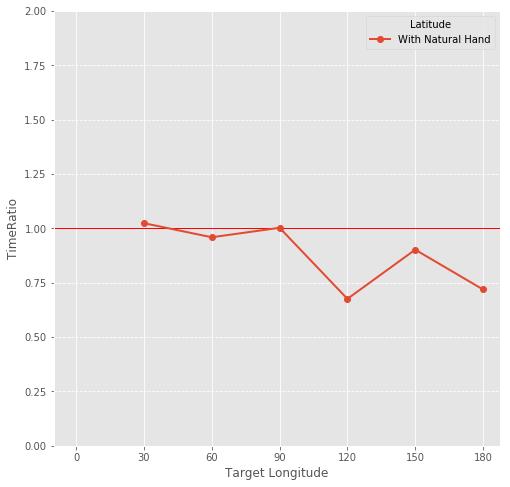

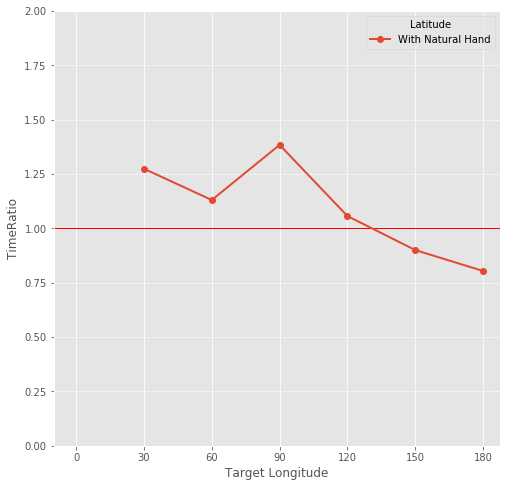

groupTimeRatio
(1, 1, 6)
Reading ../Users/16/3.txt
Reading ../Users/16/4.txt
Reading ../Users/16/5.txt
(1, 6)
(1, 6)
(1, 6)
Reading ../Users/16/3.txt
Reading ../Users/16/4.txt
Reading ../Users/16/5.txt
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)


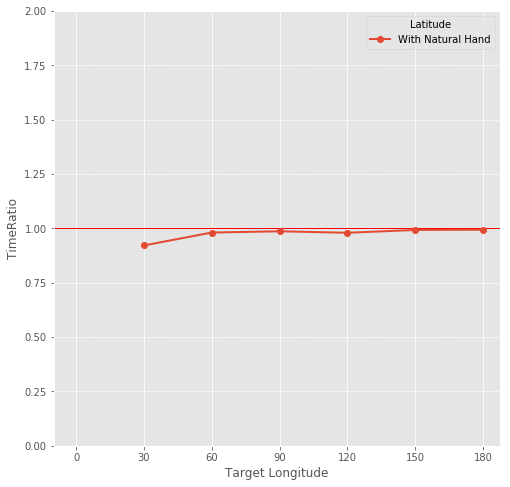

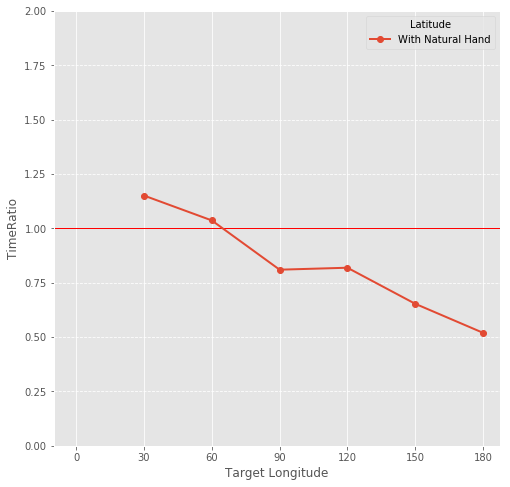

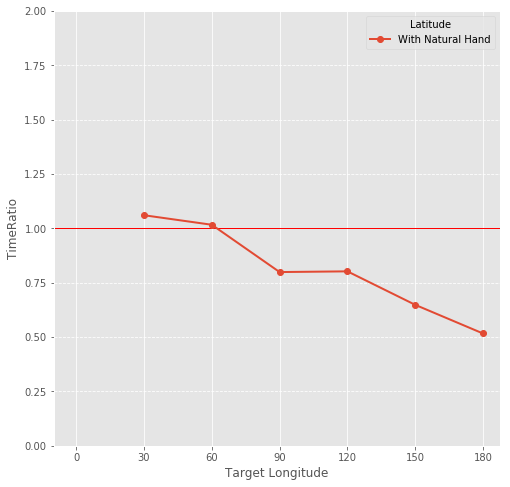

groupTimeRatio
(2, 1, 6)
Reading ../Users/17/3.txt
Reading ../Users/17/4.txt
Reading ../Users/17/5.txt
(1, 6)
(1, 6)
(1, 6)
Reading ../Users/17/3.txt
Reading ../Users/17/4.txt
Reading ../Users/17/5.txt
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)


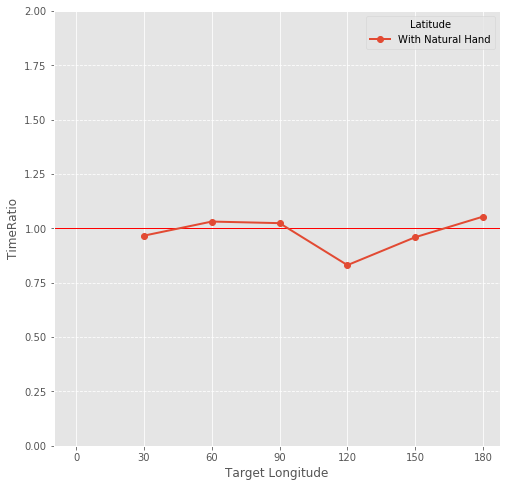

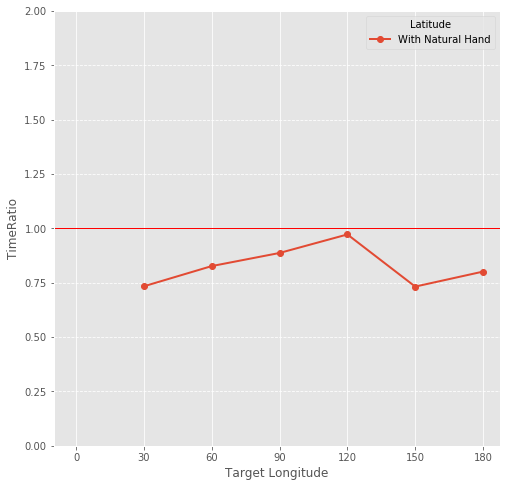

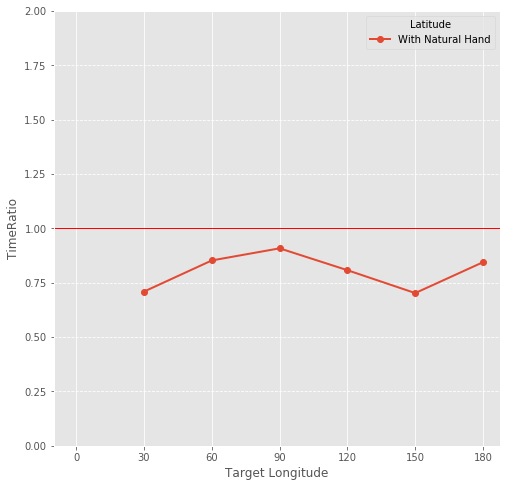

groupTimeRatio
(3, 1, 6)
Reading ../Users/18/3.txt
Reading ../Users/18/4.txt
Reading ../Users/18/5.txt
(1, 6)
(1, 6)
(1, 6)
Reading ../Users/18/3.txt
Reading ../Users/18/4.txt
Reading ../Users/18/5.txt
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)


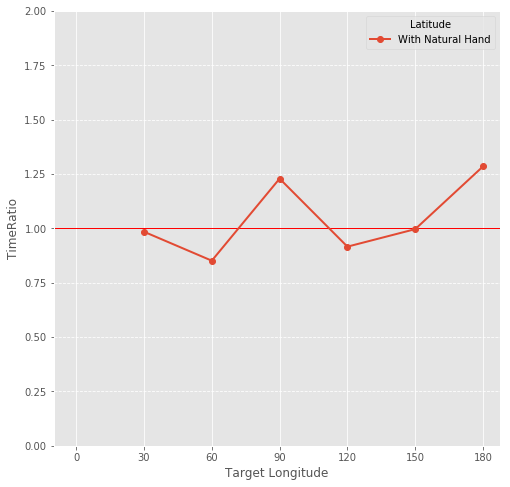

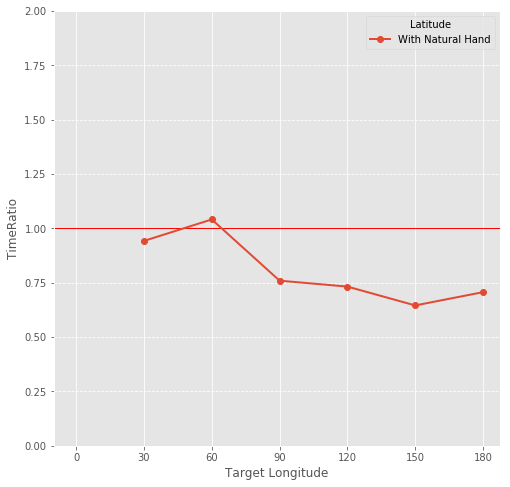

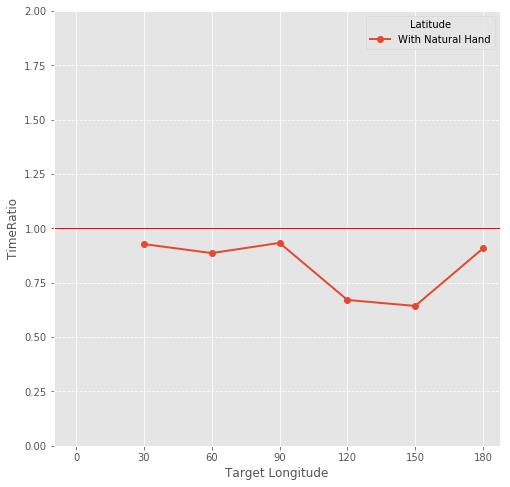

groupTimeRatio
(4, 1, 6)
Reading ../Users/19/3.txt
Reading ../Users/19/4.txt
Reading ../Users/19/5.txt
(1, 6)
(1, 6)
(1, 6)
Reading ../Users/19/3.txt
Reading ../Users/19/4.txt
Reading ../Users/19/5.txt
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)


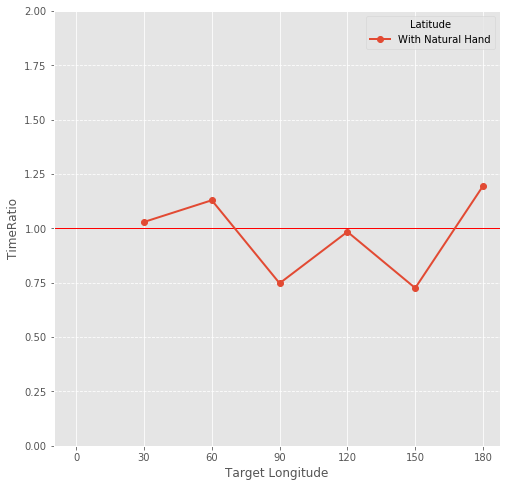

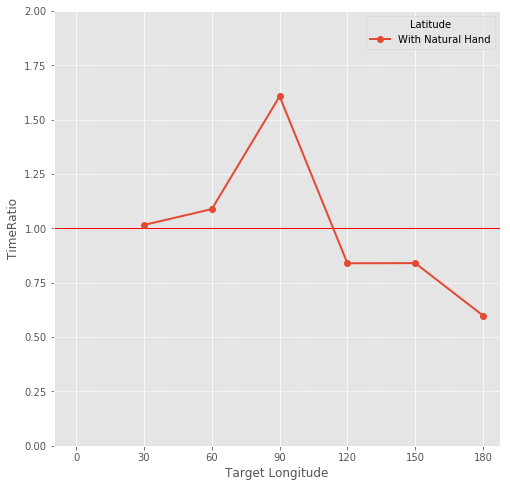

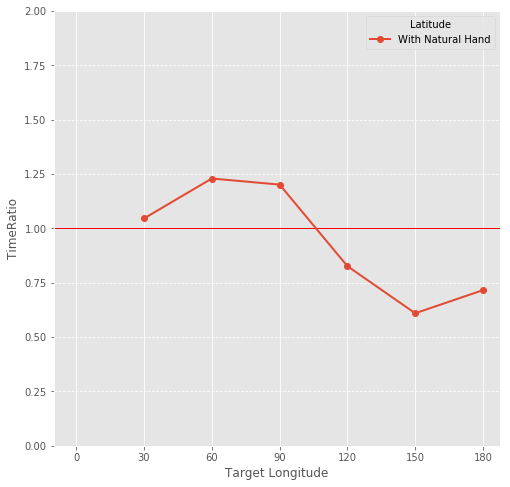

groupTimeRatio
(5, 1, 6)
Reading ../Users/15/3.txt
Reading ../Users/15/4.txt
Reading ../Users/15/5.txt
(1, 6)
(1, 6)
(1, 6)
Reading ../Users/15/3.txt
Reading ../Users/15/4.txt
Reading ../Users/15/5.txt
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)
1
6
(1, 6)
(1, 6)
(1, 6)


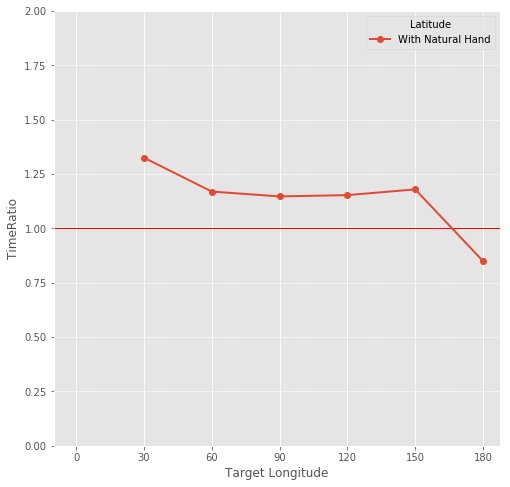

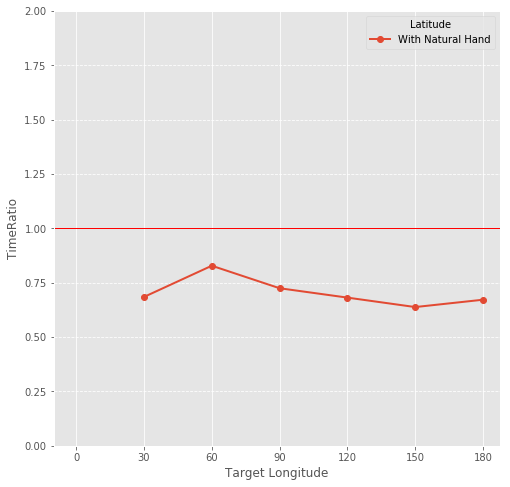

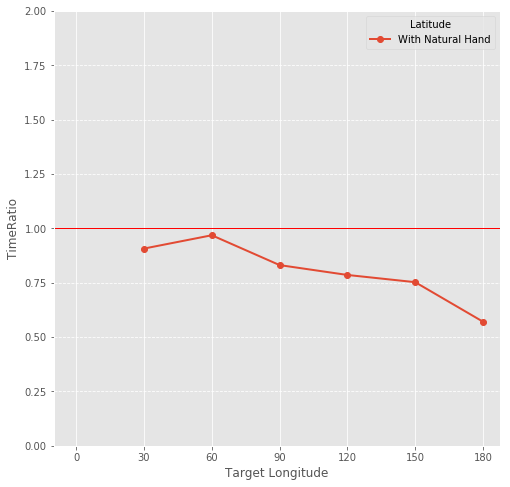

groupTimeRatio
(6, 1, 6)


In [2]:
fig, ax = plt.subplots(figsize=(8,8))
groupSpeed1=[]
groupSpeed2=[]
groupSpeed3=[]
ratio=[[],[],[]]
overallTime1=[]
overallTime2=[]
groupTime1=[]
groupTime2=[]
groupTime3=[]
groupTimeRatio=[]

groupTimeRatio1_2=[]
groupTimeRatio2_3=[]
groupTimeRatio1_3=[]


###################### choose user
#users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
users=[14,16,17,18,19,15]
######################



for uid in range(len(users)):
    baseFolder=str(users[uid])

    idx=[3,4,5]
    #idx=[1,2]

   # for i in range(len(idx)):
    #print("Trial 1"+str(i))
    userTimeMean1,userTimeStd1=readTime("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    #print("Trial 2"+str(i))
    userTimeMean2,userTimeStd2=readTime("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    #t3=read_plot2("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    userTimeMean3,userTimeStd3=readTime("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    #s1 = make_speed(t1)
    #print(t1)
    #s2 = make_speed(t2)
    #s3 = make_speed(t3)

    #r2=make_ratio(t1,t3)
    #r3=make_ratio(t2,t3)
    
    #overallTime1.append(ot1)
    #overallTime2.append(ot2)
    groupTime1.append(userTimeMean1)
    print(np.array(userTimeMean1).shape)
    groupTime2.append(userTimeMean2)
    print(np.array(userTimeMean2).shape)
    groupTime3.append(userTimeMean3)
    print(np.array(userTimeMean3).shape)

    
    
    
    userSpeedMean1, userSpeedStd1 = readSpeed("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    userSpeedMean2, userSpeedStd2 = readSpeed("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    userSpeedMean3, userSpeedStd3 = readSpeed("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    #ts3, tsdev3 = read_plot3("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    
    groupSpeed1.append(userSpeedMean1)
    groupSpeed2.append(userSpeedMean2)
    groupSpeed3.append(userSpeedMean3)
    
    #print(np.array(ts1).shape)
    #print(str(ts1))
    #print(np.array(tsdev1).shape)
    
    #plotbar(r1)
    #plotratio(r1)
    #plotcontrast(s1[0],s2[0],s3[0]) # angle cal is not correct
    
    if (len(idx)==2):    
        #plotcontrast(ts1[0],ts1[1],ts1[2],tsdev1[0],tsdev1[1],tsdev1[2])
        #plotcontrast(ts2[0],ts2[1],ts2[2],tsdev2[0],tsdev2[1],tsdev2[2])
        ratio1,log1 = make_ratio_r(userTimeMean1,userTimeMean2)
        print(np.array(ratio1).shape)
        print(str(ratio1))
    
        ratio2,log2 = make_ratio_rpluszero(userTimeMean1,userTimeMean2)

        groupTimeRatio.append(ratio2)
        print('groupTimeRatio')
        print(np.array(groupTimeRatio).shape)
        #print(str(ratio1))
        #print(str(r1))
        plotRatio('Ratio', 'Time', ratio1)
        plotRatio('Log', 'Time', log1)

    #plotcontrast(s1[3],s2[3]) #all 3
    #plotratio(r3)
    
    if (len(idx)==3):
        ratio1_2,log1_2 = make_ratio_r(userTimeMean1,userTimeMean2)
        print(np.array(ratio1_2).shape)
        ratio2_3,log2_3 = make_ratio_r(userTimeMean2,userTimeMean3)
        print(np.array(ratio2_3).shape)
        ratio1_3,log1_3 = make_ratio_r(userTimeMean1,userTimeMean3)
        print(np.array(ratio1_3).shape)
        
        plotRatio('Ratio', 'Time', ratio1_2)
        plotRatio('Ratio', 'Time', ratio2_3)
        plotRatio('Ratio', 'Time', ratio1_3)
        
        groupTimeRatio1_2.append(ratio1_2)
        groupTimeRatio2_3.append(ratio2_3)
        groupTimeRatio1_3.append(ratio1_3)
        
        print('groupTimeRatio')
        print(np.array(groupTimeRatio1_2).shape)
        


In [7]:
def calOverall(data):
    
    meanR=[]
    stdR=[]
    
    for k in range(len(data)):
        temp=[]
        for i in range(3):
            for j in range(7):
                if (i==1 and j==0):
                    temp.append(0)
                    continue
                temp.append(data[k][i][j])
        meanR.append(np.mean(temp))
        stdR.append(np.std(temp))
        
    return meanR, stdR


def calPoint(data):
    
    temp=[]
    
    for i in range(3):
        temp.append([])
        for j in range(7):
            temp[i].append([])
            for k in range(len(data)):
                if (i==1 and j==0):
                    temp[i][j].append(0)
                    continue
                temp[i][j].append(data[k][i][j])
    
    return temp



def calLon(data):
    
    meanR=[]
    stdR=[]
    
    for j in range(7):
        temp=[]
        for k in range(len(data)):
            for i in range(3):
                if (i==1 and j==0):
                    temp.append(0)
                    continue
                temp.append(data[k][i][j])
        meanR.append(np.mean(temp))
        stdR.append(np.std(temp))
        
    return meanR, stdR



def calLat(data):
    
    meanR=[]
    stdR=[]
    
    for i in range(3):
        temp=[]
        for j in range(7):
            for k in range(len(data)):
                if (i==1 and j==0):
                    temp.append(0)
                    continue
                temp.append(data[k][i][j])
        meanR.append(np.mean(temp))
        stdR.append(np.std(temp))
        
    return meanR, stdR
    


def calMean(data):

    meanR=[]
    stdR=[]
    
    #print(len(data[0]))
    
    for i in range(3): # 3 when all 3
        meanR.append([])
        stdR.append([])
        
        for j in range(7):
            r=[]
            if (i==1 and j==0):
                meanR[i].append(0)
                stdR[i].append(0)
                continue
            for k in range(len(data)):
                #print("i=" + str(i) + ",j=" + str(j) + ",k=" + str(k)) 
                r.append(data[k][i][j])
                #print("ok!")
            
            #print("RRR")
            #print(str(r))
            
            meanR[i].append(np.mean(r))
            stdR[i].append(np.std(r))
            
    #print(np.array(meanR).shape)
    
    return meanR, stdR


def outputList(data1,data2, kind):
    
    file = open("t-test.txt","a")
    file.write(kind)
    file.write("\n")
    
    for i in range(len(data1)):
        file.write("user")
        file.write(str(i+1))
        file.write("\t")
        file.write(str(data1[i]))
        file.write("\t")
        file.write(str(data2[i]))
        file.write("\n")
        
    file.write("\n\n\n")
    print(kind + 'output success!')
    
    
# for 3,4,5 only
if (len(idx)==3):
    timeMean1, timeStd1 = calMean(groupTime1)
    timeMean2, timeStd2 = calMean(groupTime2)
    timeMean3, timeStd3 = calMean(groupTime3)
    print('groupTime1')
    print(np.array(groupTime1).shape)
    print('groupTimeRatio')
    print(np.array(groupTimeRatio).shape)
    
#speedMean1, speedStd1 = calMean(speed1)
#print(str(speedMean1),str(speedStd1))
#speedMean2, speedStd2 = calMean(speed2)
#speedMean3, speedStd3 = calMean(speed3) 

# for 1,2 only 
if (len(idx)==2):
    speedMean1, speedStd1 = calMean(groupSpeed1)
    speedMean2, speedStd2 = calMean(groupSpeed2)
    print(np.array(speedMean1).shape, np.array(speedStd1).shape)

    timeMean1, timeStd1 = calMean(groupTime1)
    timeMean2, timeStd2 = calMean(groupTime2)
    print('groupTime1')
    print(np.array(groupTime1).shape)
    print('groupTimeRatio')
    print(np.array(groupTimeRatio).shape)
    timeRatioMean, timeRatioStd = calMean(groupTimeRatio)


    
#print(np.array(speedMean1).shape)
#print(np.array(speed1).shape)
#print(meanR,StdR)
#plotratio(meanR,StdR)
#plotcontrast(ratioMean[0],ratioMean[1],ratioMean[2])

#plotcontrast(speedMean1[0],speedMean2[0],speedMean3[0], speedStd1[0], speedStd2[0], speedStd3[0])
#plotcontrast(speedMean1[0],speedMean1[1],speedMean1[2], speedStd1[0], speedStd1[1], speedStd1[2])
#plotcontrast(speedMean2[0],speedMean2[1],speedMean2[2], speedStd2[0], speedStd2[1], speedStd2[2])

#plotcontrast2(speedMean1, speedStd1)
#plotcontrast2(speedMean2, speedStd2)

##plotcontrast3(speedMean1, speedMean2, speedStd1, speedStd2)
##plotcontrast3(timeMean1, timeMean2, timeStd1, timeStd2)

overallTimeMean1, overallTimeStd1 = calOverall(groupTime1)
overallTimeMean2, overallTimeStd2 = calOverall(groupTime2)
overallSpeedMean1, overallSpeedStd1 = calOverall(groupSpeed1)
overallSpeedMean2, overallSpeedStd2 = calOverall(groupSpeed2)


plotOverall(overallTimeMean1, overallTimeStd1, overallTimeMean2, overallTimeStd2, 'Time')
plotOverall(overallSpeedMean1, overallSpeedStd1, overallSpeedMean2, overallSpeedStd2, 'Speed')



outputList(overallTimeMean1, overallTimeMean2, 'overall time')
outputList(overallSpeedMean1, overallSpeedMean2, 'overall speed')


plotcontrast4(timeMean1, timeMean2, timeStd1, timeStd2, 'Time') # plot 4 graph about time
plotcontrast4(speedMean1, speedMean2, speedStd1, speedStd2, 'Speed') # plot 4 graph about time

ratioSpeedMean, logSpeedMean = make_ratio_r(speedMean1, speedMean2)
ratioTimeMean, logTimeMean = make_ratio_r(timeMean1, timeMean2)

plotRatio('Log', 'Speed', logSpeedMean)
plotRatio('Ratio', 'Speed', ratioSpeedMean)
plotRatio('Log', 'Time', logTimeMean)
plotRatio('Ratio', 'Time', ratioTimeMean)
plotRatio('Ratio', 'Time', timeRatioMean, timeRatioStd)


lonTimeMean1, lonTimeStd1 = calLon(groupTime1)
lonTimeMean2, lonTimeStd2 = calLon(groupTime2)
outputList(lonTimeMean1, lonTimeMean2, 'longitude time')


pointTime1=calPoint(groupTime1)
pointTime2=calPoint(groupTime2)
print(np.array(groupTime1).shape)
print(np.array(pointTime1).shape)

#for i in range(3):
#    for j in range(7):
#        outputList(pointTime1[i][j], pointTime2[i][j], 'time at' + str(30*i-30)+','+str(30*j))

IndexError: list index out of range

In [8]:
ttest_ind(overallTimeMean1,overallTimeMean2)

NameError: name 'overallTimeMean1' is not defined

In [9]:
ttest_rel(overallTimeMean1,overallTimeMean2)

NameError: name 'overallTimeMean1' is not defined

In [ ]:

pointTtest=[]
for k in range(1):
    for i in range(3):
        pointTtest.append([])
        for j in range(7):
            if (i==1 and j==0):
                pointTtest[i].append(0)
                continue
            temp1,temp2=ttest_rel(pointTime1[i][j],pointTime2[i][j])
            pointTtest[i].append(temp2)

print(np.array(pointTime1).shape)
print(np.array(pointTtest).shape)
print(str(pointTtest))


#plt.figure(1, figsize = (10, 6))
#ax = plt.gca()
#for i in range(3):
#    for j in range(7):
#        ax.add_patch(plt.Circle((j+1,i+1),radius=pointTtest[i][j]))
#plt.xlim(0,10)
#plt.ylim(0,6)
#plt.show

plotContrastSingle(pointTtest, 'p-value')


In [ ]:
ttest_ind(overallSpeedMean1,overallSpeedMean2)

In [ ]:
stats.ttest_rel(overallSpeedMean1,overallSpeedMean2)